<a href="https://colab.research.google.com/github/Raoina/Spectra-2-Image/blob/main/notebooks/image_Transformation/03_MTF_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!git clone https://github.com/Raoina/Spectra-2-Image

Cloning into 'Spectra-2-Image'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 314 (delta 10), reused 3 (delta 3), pack-reused 283 (from 2)
Receiving objects: 100% (314/314), 110.71 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (83/83), done.
Updating files: 100% (101/101), done.


In [3]:

file_path = "/content/Spectra-2-Image/siware_dataset/split_avg_unique_488/python/spectra_train_488.csv"

# **Si-Ware**

In [4]:
import pandas as pd

df = pd.read_csv(file_path)

df.head()

,3921.568654,3935.185205,3948.801765,3962.418316,3976.034876,3989.651427,4003.267987,4016.884537,4030.501097,4044.117648,...,7284.857826,7298.474386,7312.090937,7325.707497,7339.324048,7352.940608,7366.557159,7380.173719,7393.790269,7407.406829
0,7.729080,7.622415,7.546208,7.481664,7.423155,7.377601,7.358989,7.381517,7.454154,7.577913,...,34.616084,35.288379,35.845357,36.327769,36.777222,37.228529,37.695179,38.173677,38.652607,39.125314
1,9.720940,9.584006,9.485654,9.401768,9.326291,9.270802,9.256881,9.306069,9.431605,9.634163,...,42.449703,43.100897,43.648566,44.136925,44.609373,45.097435,45.608556,46.131176,46.646221,47.142563
2,7.551404,7.444440,7.367629,7.300275,7.237015,7.186719,7.165871,7.190576,7.270485,7.406037,...,34.907780,35.560699,36.103651,36.578961,37.026430,37.475247,37.932452,38.389652,38.834516,39.264430
3,6.526686,6.434280,6.366056,6.301643,6.235700,6.175937,6.136361,6.129914,6.163474,6.236180,...,27.640183,28.252847,28.764077,29.212927,29.634762,30.056096,30.485576,30.919745,31.351121,31.777759
4,6.840954,6.757292,6.697071,6.637614,6.573048,6.512227,6.471038,6.464014,6.498781,6.574416,...,28.069196,28.715024,29.254844,29.724470,30.160514,30.594707,31.040131,31.494608,31.948344,32.395361


In [5]:
df.shape

(488, 257)

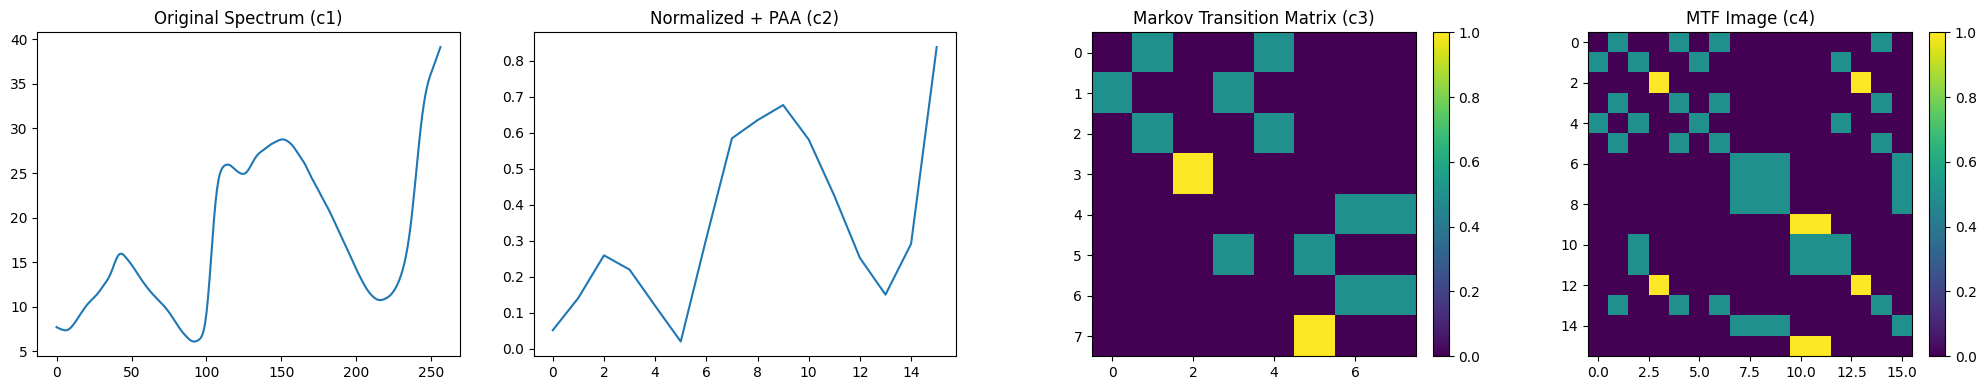

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# ---------- 1. Example: take one spectrum from df ----------
row_index = 0
spectrum = df.iloc[row_index].values.astype(float)

# ---------- 2. Normalization ----------
def normalize_to_0_1(series):
    mn, mx = series.min(), series.max()
    if mx == mn:
        return np.zeros_like(series)
    return (series - mn) / (mx - mn)

normed_series = normalize_to_0_1(spectrum)

# ---------- 3. Apply PAA ----------
def paa(series, segments):
    n = len(series)
    win_size = n // segments
    return np.array([series[i*win_size:(i+1)*win_size].mean() for i in range(segments)])

paa_size = 16
paa_series = paa(normed_series, paa_size)

# ---------- 4. Discretization into Q bins ----------
Q = 8
scaler = KBinsDiscretizer(n_bins=Q, encode="ordinal", strategy="quantile")
discrete_seq = scaler.fit_transform(paa_series.reshape(-1, 1)).astype(int).flatten()

# ---------- 5. Build Markov transition matrix ----------
markov_matrix = np.zeros((Q, Q))
for (a, b) in zip(discrete_seq[:-1], discrete_seq[1:]):
    markov_matrix[a, b] += 1
markov_matrix = markov_matrix / markov_matrix.sum(axis=1, keepdims=True)  # normalize to probs

# ---------- 6. Build MTF image ----------
n = len(discrete_seq)
mtf = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        mtf[i, j] = markov_matrix[discrete_seq[i], discrete_seq[j]]

# ---------- 7. Visualization ----------
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

# (c1) Original NIR spectrum
axs[0].plot(spectrum)
axs[0].set_title("Original Spectrum (c1)")

# (c2) Normalized + PAA
axs[1].plot(paa_series)
axs[1].set_title("Normalized + PAA (c2)")

# (c3) Markov Transition Matrix
im1 = axs[2].imshow(markov_matrix, cmap="viridis")
axs[2].set_title("Markov Transition Matrix (c3)")
plt.colorbar(im1, ax=axs[2], fraction=0.046, pad=0.04)

# (c4) MTF Image
im2 = axs[3].imshow(mtf, cmap="viridis")
axs[3].set_title("MTF Image (c4)")
plt.colorbar(im2, ax=axs[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import os
from sklearn.preprocessing import KBinsDiscretizer
from matplotlib import cm
from PIL import Image
import gc

# ---------- Folder to save MTF images ----------
mtf_dir = "/content/drive/MyDrive/images_16*16/MTF_16_Q_10"
os.makedirs(mtf_dir, exist_ok=True)

# ---------- Normalization ----------
def normalize_to_0_1(series):
    mn, mx = series.min(), series.max()
    if mx == mn:
        return np.zeros_like(series)
    return (series - mn) / (mx - mn)

# ---------- PAA with remainder distribution ----------
def paa_distribute(series, segments):
    n = len(series)
    base = n // segments
    rem = n % segments
    res = []
    idx = 0
    for i in range(segments):
        seg_len = base + (1 if i < rem else 0)
        seg = series[idx: idx+seg_len]
        res.append(seg.mean())
        idx += seg_len
    return np.array(res)

# ---------- Build Markov transition matrix ----------
def build_markov(discrete_seq, Q):
    markov_matrix = np.zeros((Q, Q))
    for (a, b) in zip(discrete_seq[:-1], discrete_seq[1:]):
        markov_matrix[a, b] += 1
    # normalize to probabilities
    markov_matrix = markov_matrix / (markov_matrix.sum(axis=1, keepdims=True) + 1e-8)
    return markov_matrix

# ---------- Build MTF image ----------
def build_mtf(discrete_seq, markov_matrix):
    n = len(discrete_seq)
    mtf = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            mtf[i, j] = markov_matrix[discrete_seq[i], discrete_seq[j]]
    return mtf

# ---------- Save matrix as image ----------
def save_matrix(mat, path):
    rgba = cm.viridis(mat)
    rgb = (rgba[:, :, :3] * 255).astype(np.uint8)
    Image.fromarray(rgb).save(path)

# ---------- Parameters ----------
segments = 16      # PAA size
Q = 10              # Quantization bins
batch_size = 100
num_samples = len(df)

# ---------- Main Loop ----------
for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    print(f"Processing MTF batch {batch_start} .. {batch_end-1}")

    for idx in range(batch_start, batch_end):
        mtf_path = os.path.join(mtf_dir, f"sample_{idx}.png")
        if os.path.exists(mtf_path):
            continue

        # 1. Load spectrum
        spectrum = df.iloc[idx].values.astype(float)

        # 2. Normalize (0-1)
        normed_series = normalize_to_0_1(spectrum)

        # 3. PAA
        paa_series = paa_distribute(normed_series, segments)

        # 4. Discretize
        scaler = KBinsDiscretizer(n_bins=Q, encode="ordinal", strategy="quantile")
        discrete_seq = scaler.fit_transform(paa_series.reshape(-1, 1)).astype(int).flatten()

        # 5. Markov matrix
        markov_matrix = build_markov(discrete_seq, Q)

        # 6. MTF
        mtf = build_mtf(discrete_seq, markov_matrix)

        # 7. Save image
        save_matrix(mtf, mtf_path)

        # cleanup
        del spectrum, normed_series, paa_series, discrete_seq, markov_matrix, mtf
        gc.collect()

    print(f"✅ MTF batch {batch_start} to {batch_end-1} done.")


Processing MTF batch 0 .. 99
✅ MTF batch 0 to 99 done.
Processing MTF batch 100 .. 199
✅ MTF batch 100 to 199 done.
Processing MTF batch 200 .. 299
✅ MTF batch 200 to 299 done.
Processing MTF batch 300 .. 399
✅ MTF batch 300 to 399 done.
Processing MTF batch 400 .. 487
✅ MTF batch 400 to 487 done.


In [ ]:
import shutil
import os
from google.colab import files

# Define the folders to be included in the zip file
folders_to_zip = ["MTF_16_Q_10", "MTF_65_Q_10"]

# Create a temporary directory to hold the folders
temp_dir = "temp_mtf_folders"
os.makedirs(temp_dir, exist_ok=True)

# Move the specified folders into the temporary directory
for folder in folders_to_zip:
    if os.path.exists(folder):
        shutil.move(folder, temp_dir)
    else:
        print(f"Warning: Folder '{folder}' not found.")

# Compress the temporary directory
shutil.make_archive("MTF", 'zip', temp_dir)

# Download the zip file
files.download("MTF.zip")

# Clean up the temporary directory
shutil.rmtree(temp_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **LUCAS**

In [ ]:
file_path = '/content/drive/MyDrive/LUCAS.SOIL_corr.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(file_path)

df.head()

/tmp/ipython-input-3672932280.py:3: DtypeWarning: Columns (1,2,4216,4231,4234,4237,4274) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Unnamed: 0,sample.ID,ID,date,spc.400,spc.400.5,spc.401,spc.401.5,spc.402,spc.402.5,...,WRBLV1,WRBADJ1,PARMADO1,PARMADO2,PARMADO3,PARMASE1,PARMASE2,PARMASE3,MIN_TOP,mineral
0,4,100,100,2011-01-24 16:02:25,0.831705,0.839111,0.846473,0.853773,0.860988,0.868098,...,CM,dy,3.0,31.0,310.0,5.0,56.0,561.0,KQ,mineral
1,5,1000,1000,2010-09-30 14:50:01,0.706027,0.714901,0.723727,0.732480,0.741142,0.749684,...,CM,dy,3.0,31.0,311.0,3.0,31.0,310.0,KQ,mineral
2,6,10000,10000,2010-10-19 12:06:16,0.666238,0.676472,0.686654,0.696757,0.706753,0.716615,...,CM,ca,2.0,21.0,214.0,0.0,0.0,0.0,MS,mineral
3,7,10001,10001,2010-10-19 15:00:01,0.698136,0.706548,0.714909,0.723197,0.731384,0.739448,...,CM,dy,3.0,31.0,310.0,4.0,42.0,420.0,KQ,mineral
4,8,10002,10002,2011-04-30 12:26:27,0.675433,0.684820,0.694163,0.703438,0.712620,0.721693,...,LV,ha,7.0,71.0,710.0,6.0,62.0,620.0,M,mineral


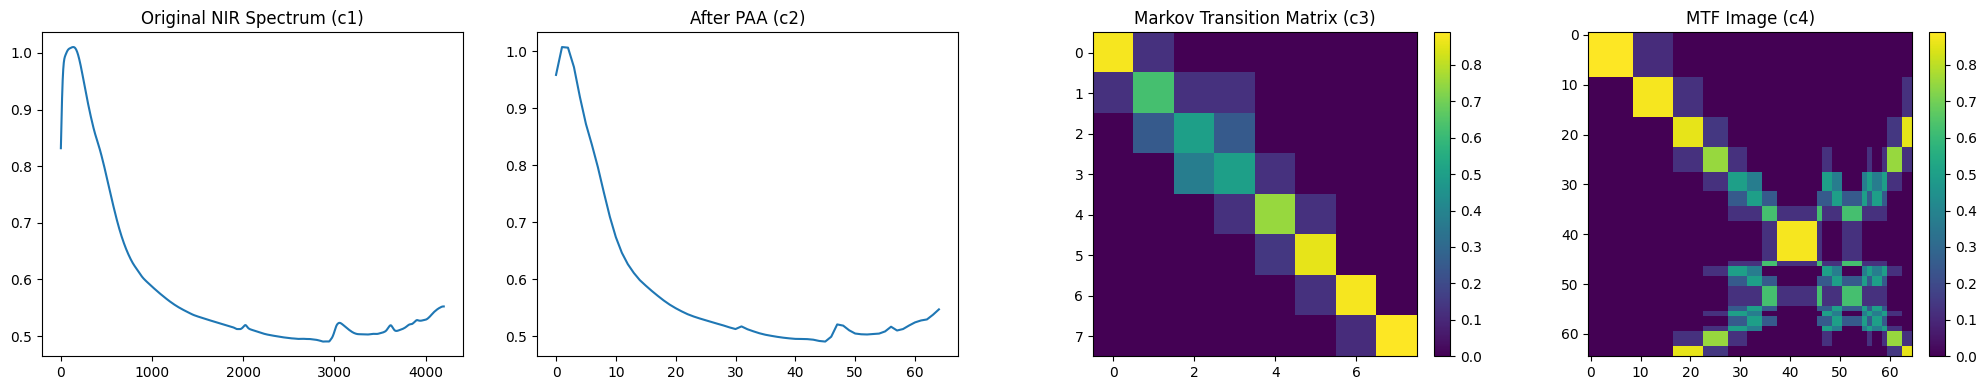

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# ---------- 1. Example: take one spectrum ----------
row = df.iloc[0]
spectrum = row.filter(like="spc.")
intensity = spectrum.values.astype(float)

# ---------- 2. Apply PAA (reduce length) ----------
def paa(series, segments):
    n = len(series)
    win_size = n // segments
    return np.array([series[i*win_size:(i+1)*win_size].mean() for i in range(segments)])

paa_size = 65  # smaller sequence for demo
paa_series = paa(intensity, paa_size)

# ---------- 3. Discretization into Q states ----------
Q = 8  # number of quantile bins
scaler = KBinsDiscretizer(n_bins=Q, encode="ordinal", strategy="quantile")
discrete_seq = scaler.fit_transform(paa_series.reshape(-1, 1)).astype(int).flatten()

# ---------- 4. Build Markov transition matrix ----------
markov_matrix = np.zeros((Q, Q))
for (a, b) in zip(discrete_seq[:-1], discrete_seq[1:]):
    markov_matrix[a, b] += 1
# normalize to probabilities
markov_matrix = markov_matrix / markov_matrix.sum(axis=1, keepdims=True)

# ---------- 5. Build MTF image ----------
n = len(discrete_seq)
mtf = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        mtf[i, j] = markov_matrix[discrete_seq[i], discrete_seq[j]]

# ---------- 6. Visualization ----------
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

# (c1) Original NIR spectrum
axs[0].plot(intensity)
axs[0].set_title("Original NIR Spectrum (c1)")

# (c2) After PAA
axs[1].plot(paa_series)
axs[1].set_title("After PAA (c2)")

# (c3) Markov transition matrix
im1 = axs[2].imshow(markov_matrix, cmap="viridis")
axs[2].set_title("Markov Transition Matrix (c3)")
plt.colorbar(im1, ax=axs[2], fraction=0.046, pad=0.04)

# (c4) MTF Image
im2 = axs[3].imshow(mtf, cmap="viridis")
axs[3].set_title("MTF Image (c4)")
plt.colorbar(im2, ax=axs[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


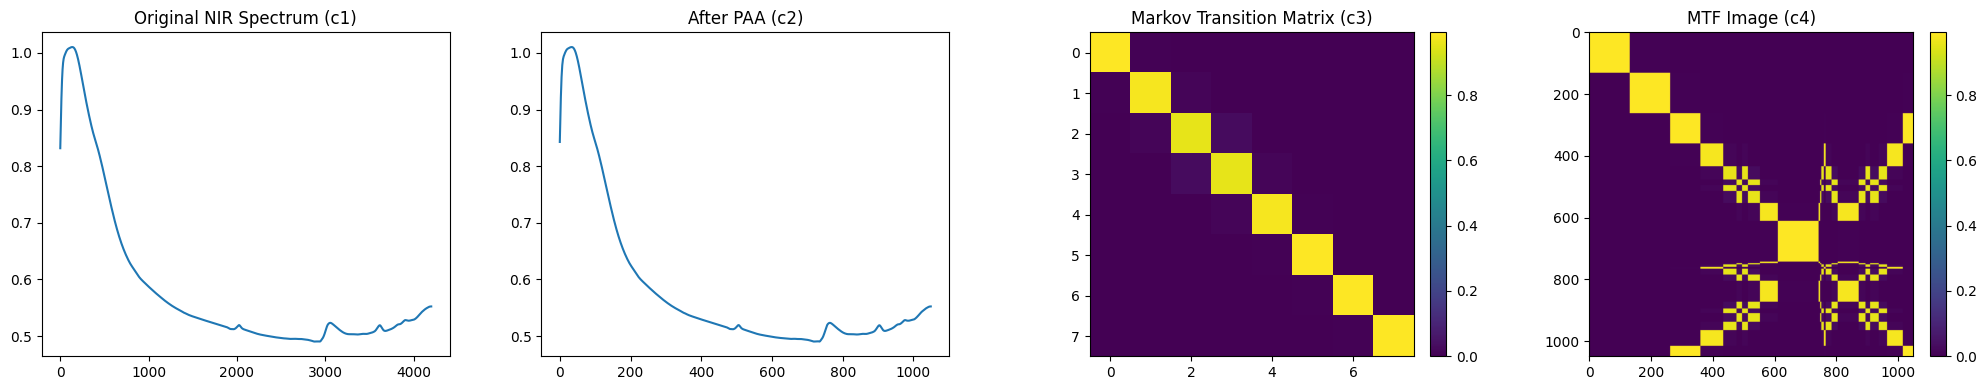

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# ---------- 1. Example: take one spectrum ----------
row = df.iloc[0]
spectrum = row.filter(like="spc.")
intensity = spectrum.values.astype(float)

# ---------- 2. Apply PAA (reduce length) ----------
def paa(series, segments):
    n = len(series)
    win_size = n // segments
    return np.array([series[i*win_size:(i+1)*win_size].mean() for i in range(segments)])

paa_size = 1050  # smaller sequence for demo
paa_series = paa(intensity, paa_size)

# ---------- 3. Discretization into Q states ----------
Q = 8  # number of quantile bins
scaler = KBinsDiscretizer(n_bins=Q, encode="ordinal", strategy="quantile")
discrete_seq = scaler.fit_transform(paa_series.reshape(-1, 1)).astype(int).flatten()

# ---------- 4. Build Markov transition matrix ----------
markov_matrix = np.zeros((Q, Q))
for (a, b) in zip(discrete_seq[:-1], discrete_seq[1:]):
    markov_matrix[a, b] += 1
# normalize to probabilities
markov_matrix = markov_matrix / markov_matrix.sum(axis=1, keepdims=True)

# ---------- 5. Build MTF image ----------
n = len(discrete_seq)
mtf = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        mtf[i, j] = markov_matrix[discrete_seq[i], discrete_seq[j]]

# ---------- 6. Visualization ----------
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

# (c1) Original NIR spectrum
axs[0].plot(intensity)
axs[0].set_title("Original NIR Spectrum (c1)")

# (c2) After PAA
axs[1].plot(paa_series)
axs[1].set_title("After PAA (c2)")

# (c3) Markov transition matrix
im1 = axs[2].imshow(markov_matrix, cmap="viridis")
axs[2].set_title("Markov Transition Matrix (c3)")
plt.colorbar(im1, ax=axs[2], fraction=0.046, pad=0.04)

# (c4) MTF Image
im2 = axs[3].imshow(mtf, cmap="viridis")
axs[3].set_title("MTF Image (c4)")
plt.colorbar(im2, ax=axs[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

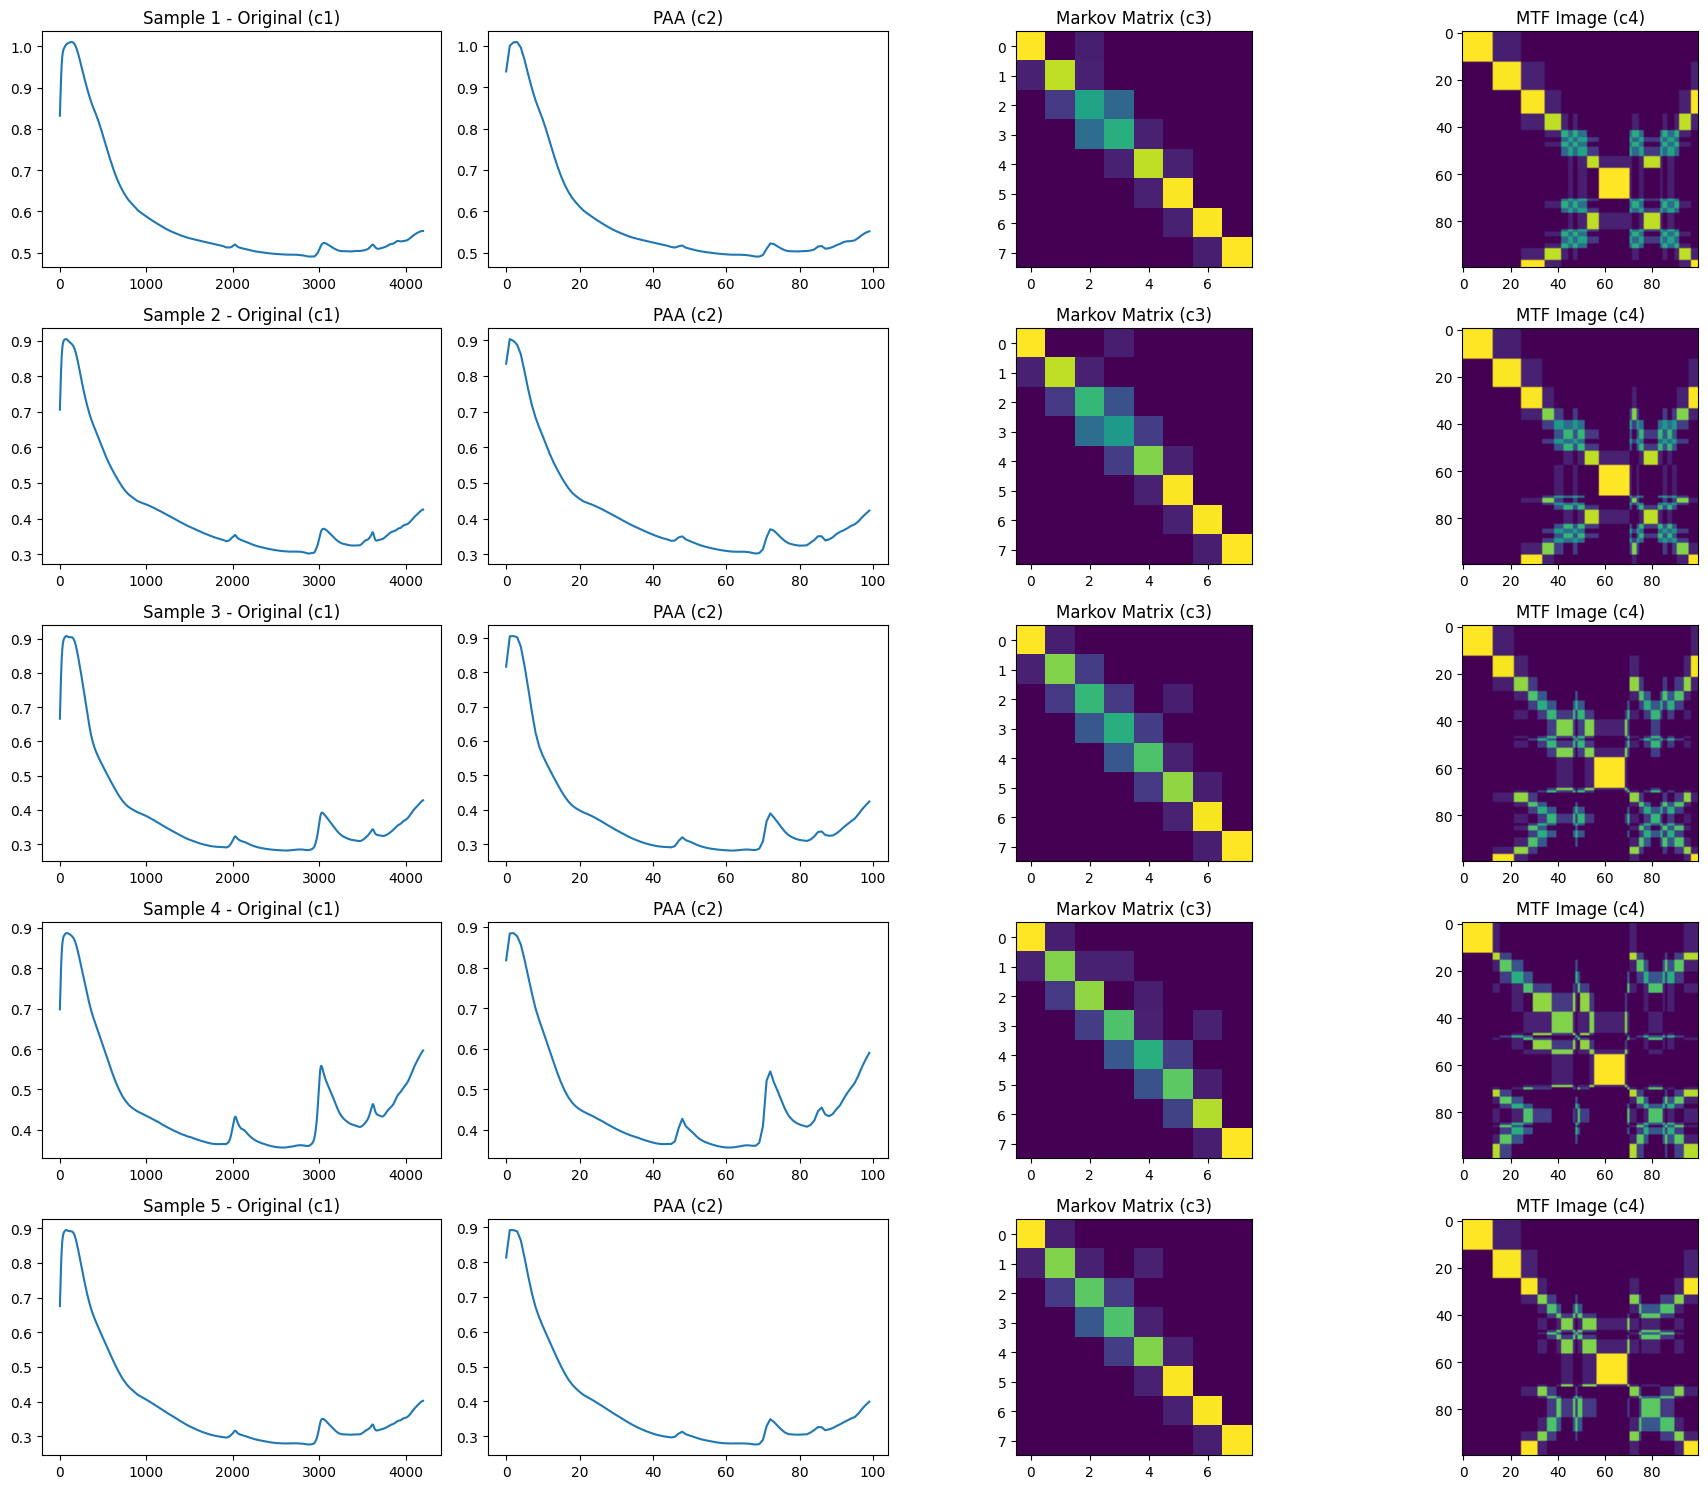

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# ---------- Helper functions ----------
def paa(series, segments):
    """Piecewise Aggregate Approximation (PAA)."""
    n = len(series)
    win_size = n // segments
    return np.array([series[i*win_size:(i+1)*win_size].mean() for i in range(segments)])

def compute_mtf(series, paa_size=100, Q=8):
    """Compute Markov Transition Field (MTF) from a spectrum."""
    # 1) Apply PAA
    paa_series = paa(series, paa_size)

    # 2) Discretization into Q bins
    scaler = KBinsDiscretizer(n_bins=Q, encode="ordinal", strategy="quantile")
    discrete_seq = scaler.fit_transform(paa_series.reshape(-1, 1)).astype(int).flatten()

    # 3) Markov transition matrix
    markov_matrix = np.zeros((Q, Q))
    for (a, b) in zip(discrete_seq[:-1], discrete_seq[1:]):
        markov_matrix[a, b] += 1
    markov_matrix = markov_matrix / (markov_matrix.sum(axis=1, keepdims=True) + 1e-8)

    # 4) Build MTF image
    n = len(discrete_seq)
    mtf = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            mtf[i, j] = markov_matrix[discrete_seq[i], discrete_seq[j]]

    return paa_series, markov_matrix, mtf

# ---------- Apply to first 5 samples ----------
num_samples = 5
samples = [df.iloc[i].filter(like="spc.").values.astype(float) for i in range(num_samples)]

fig, axs = plt.subplots(num_samples, 4, figsize=(18, 3*num_samples))

for idx, spectrum in enumerate(samples):
    paa_series, markov_matrix, mtf = compute_mtf(spectrum, paa_size=100, Q=8)

    # (c1) Original spectrum
    axs[idx, 0].plot(spectrum)
    axs[idx, 0].set_title(f"Sample {idx+1} - Original (c1)")

    # (c2) PAA sequence
    axs[idx, 1].plot(paa_series)
    axs[idx, 1].set_title("PAA (c2)")

    # (c3) Markov transition matrix
    im1 = axs[idx, 2].imshow(markov_matrix, cmap="viridis")
    axs[idx, 2].set_title("Markov Matrix (c3)")

    # (c4) MTF image
    im2 = axs[idx, 3].imshow(mtf, cmap="viridis")
    axs[idx, 3].set_title("MTF Image (c4)")

plt.tight_layout()
plt.show()


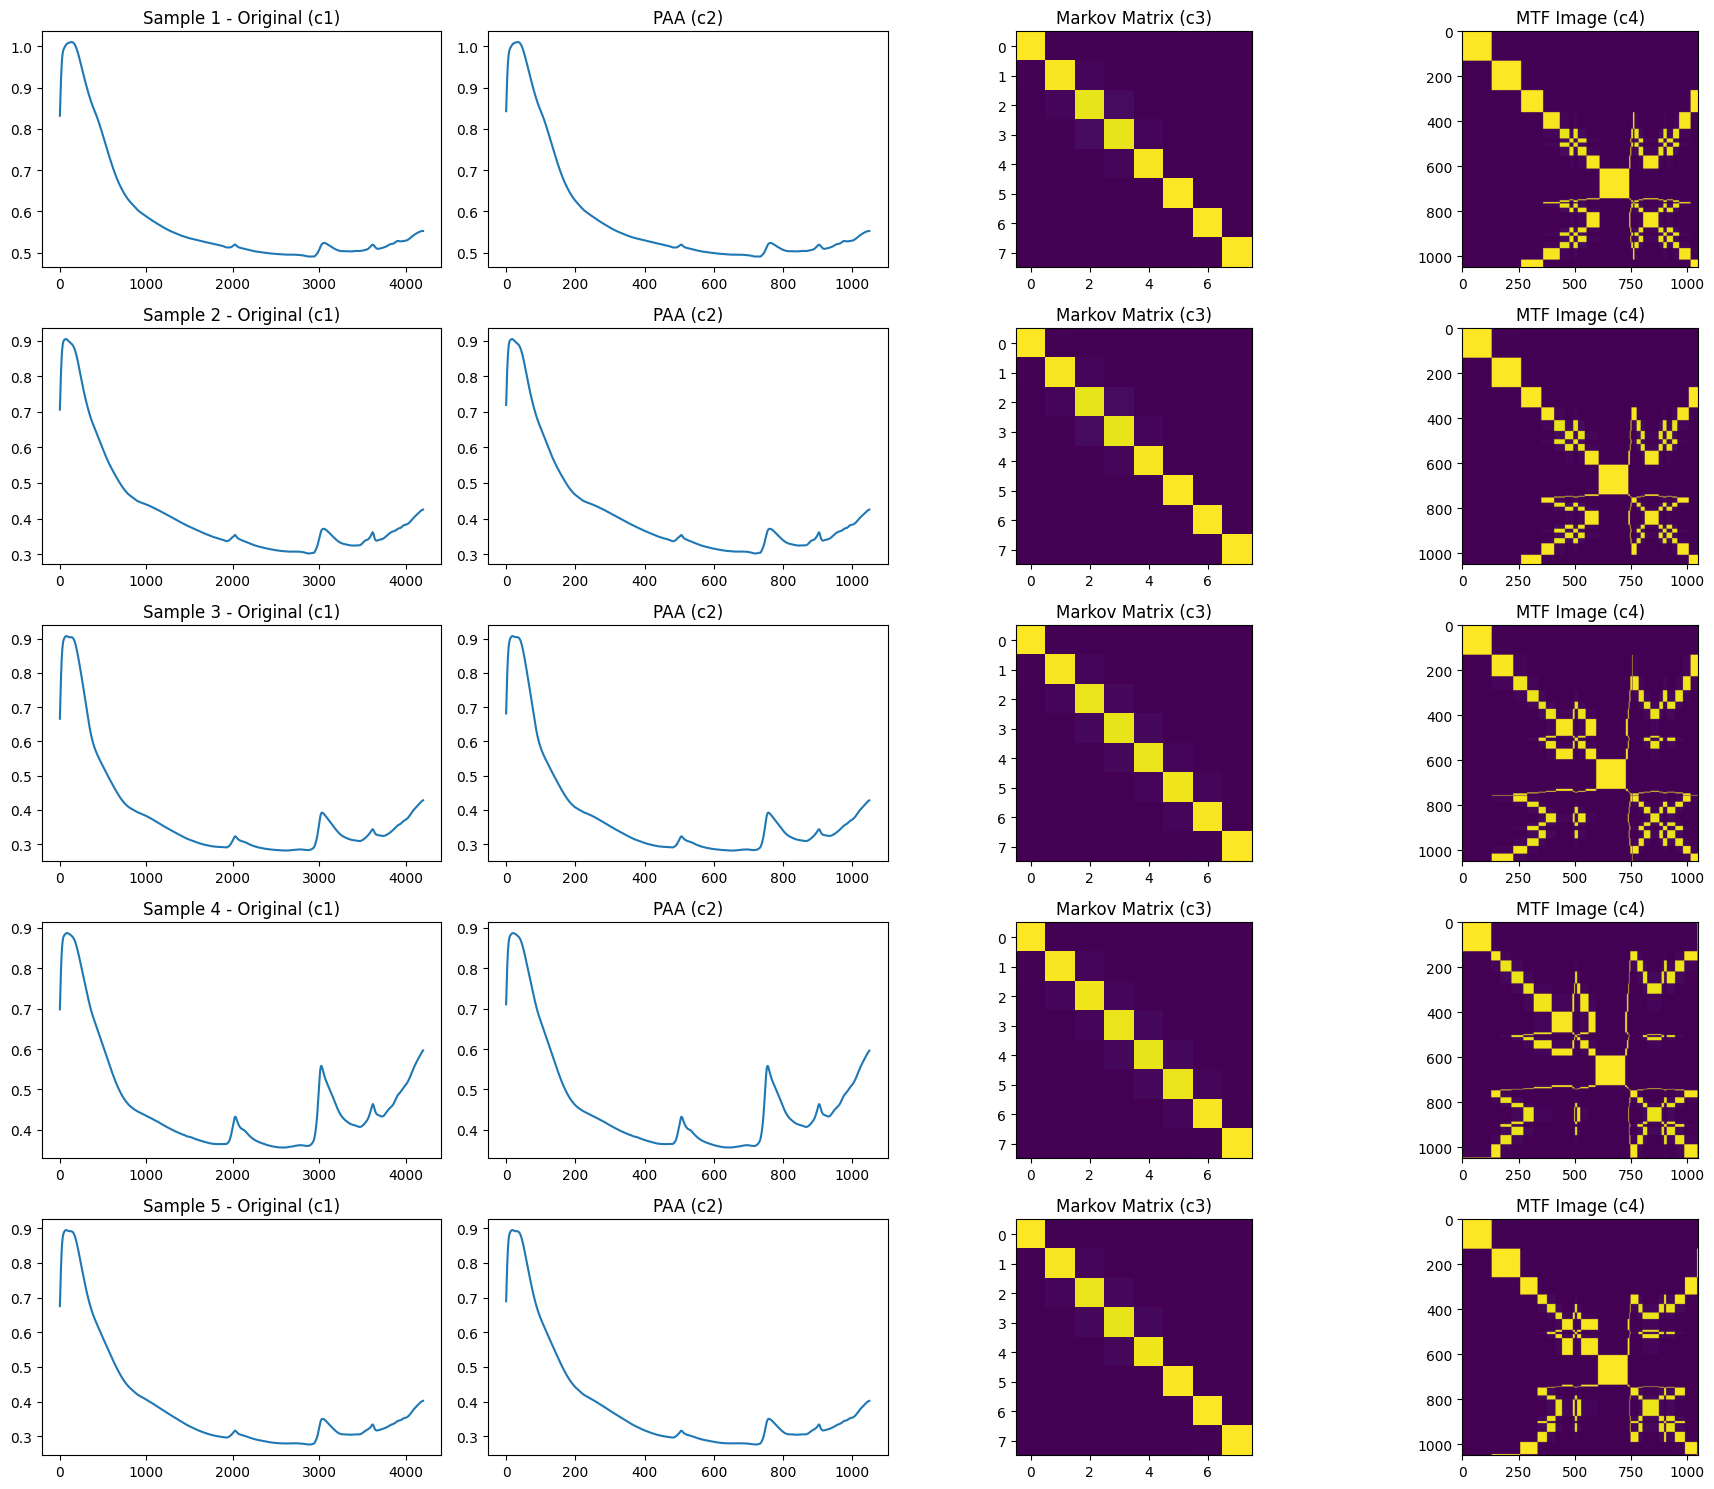

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# ---------- Helper functions ----------
def paa(series, segments):
    """Piecewise Aggregate Approximation (PAA)."""
    n = len(series)
    win_size = n // segments
    return np.array([series[i*win_size:(i+1)*win_size].mean() for i in range(segments)])

def compute_mtf(series, paa_size=100, Q=8):
    """Compute Markov Transition Field (MTF) from a spectrum."""
    # 1) Apply PAA
    paa_series = paa(series, paa_size)

    # 2) Discretization into Q bins
    scaler = KBinsDiscretizer(n_bins=Q, encode="ordinal", strategy="quantile")
    discrete_seq = scaler.fit_transform(paa_series.reshape(-1, 1)).astype(int).flatten()

    # 3) Markov transition matrix
    markov_matrix = np.zeros((Q, Q))
    for (a, b) in zip(discrete_seq[:-1], discrete_seq[1:]):
        markov_matrix[a, b] += 1
    markov_matrix = markov_matrix / (markov_matrix.sum(axis=1, keepdims=True) + 1e-8)

    # 4) Build MTF image
    n = len(discrete_seq)
    mtf = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            mtf[i, j] = markov_matrix[discrete_seq[i], discrete_seq[j]]

    return paa_series, markov_matrix, mtf

# ---------- Apply to first 5 samples ----------
num_samples = 5
samples = [df.iloc[i].filter(like="spc.").values.astype(float) for i in range(num_samples)]

fig, axs = plt.subplots(num_samples, 4, figsize=(18, 3*num_samples))

for idx, spectrum in enumerate(samples):
    paa_series, markov_matrix, mtf = compute_mtf(spectrum, paa_size=1050, Q=8)

    # (c1) Original spectrum
    axs[idx, 0].plot(spectrum)
    axs[idx, 0].set_title(f"Sample {idx+1} - Original (c1)")

    # (c2) PAA sequence
    axs[idx, 1].plot(paa_series)
    axs[idx, 1].set_title("PAA (c2)")

    # (c3) Markov transition matrix
    im1 = axs[idx, 2].imshow(markov_matrix, cmap="viridis")
    axs[idx, 2].set_title("Markov Matrix (c3)")

    # (c4) MTF image
    im2 = axs[idx, 3].imshow(mtf, cmap="viridis")
    axs[idx, 3].set_title("MTF Image (c4)")

plt.tight_layout()
plt.show()


We try Segments level to 65 and 1050 so We choose 65 for apply it on CNN architecture

#**MTF**

In [ ]:
import numpy as np
import os
from sklearn.preprocessing import KBinsDiscretizer
from matplotlib import cm
from PIL import Image
import gc

mtf_dir = "MTF_images"
os.makedirs(mtf_dir, exist_ok=True)

def paa_distribute(series, segments):
    n = len(series)
    base = n // segments
    rem = n % segments
    res = []
    idx = 0
    for i in range(segments):
        seg_len = base + (1 if i < rem else 0)
        seg = series[idx: idx+seg_len]
        res.append(seg.mean())
        idx += seg_len
    return np.array(res)

def build_markov(discrete_seq, Q):
    markov_matrix = np.zeros((Q, Q))
    for (a, b) in zip(discrete_seq[:-1], discrete_seq[1:]):
        markov_matrix[a, b] += 1
    # normalize to probabilities
    markov_matrix = markov_matrix / markov_matrix.sum(axis=1, keepdims=True)
    return markov_matrix

def build_mtf(discrete_seq, markov_matrix):
    n = len(discrete_seq)
    mtf = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            mtf[i, j] = markov_matrix[discrete_seq[i], discrete_seq[j]]
    return mtf

def save_matrix(mat, path):
    arr = mat  # already 0-1
    rgba = cm.viridis(arr)
    rgb = (rgba[:, :, :3] * 255).astype(np.uint8)
    Image.fromarray(rgb).save(path)

segments = 65
Q = 8
batch_size = 500
num_samples = len(df)

for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    print(f"Processing MTF batch {batch_start} .. {batch_end-1}")

    for idx in range(batch_start, batch_end):
        mtf_path = os.path.join(mtf_dir, f"sample_{idx}.png")
        if os.path.exists(mtf_path):
            continue

        # 1. Load spectrum
        spectrum = df.iloc[idx].filter(like="spc.").values.astype(float)

        # 2. PAA
        paa_series = paa_distribute(spectrum, segments)

        # 3. Discretization
        scaler = KBinsDiscretizer(n_bins=Q, encode="ordinal", strategy="quantile")
        discrete_seq = scaler.fit_transform(paa_series.reshape(-1, 1)).astype(int).flatten()

        # 4. Markov matrix
        markov_matrix = build_markov(discrete_seq, Q)

        # 5. MTF image
        mtf = build_mtf(discrete_seq, markov_matrix)

        # 6. Save
        save_matrix(mtf, mtf_path)

        del paa_series, discrete_seq, markov_matrix, mtf
        gc.collect()

    print(f"MTF batch {batch_start} to {batch_end-1} done ✅")

Processing MTF batch 0 .. 499
MTF batch 0 to 499 done ✅
Processing MTF batch 500 .. 999
MTF batch 500 to 999 done ✅
Processing MTF batch 1000 .. 1499
MTF batch 1000 to 1499 done ✅
Processing MTF batch 1500 .. 1999
MTF batch 1500 to 1999 done ✅
Processing MTF batch 2000 .. 2499
MTF batch 2000 to 2499 done ✅
Processing MTF batch 2500 .. 2999
MTF batch 2500 to 2999 done ✅
Processing MTF batch 3000 .. 3499
MTF batch 3000 to 3499 done ✅
Processing MTF batch 3500 .. 3999
MTF batch 3500 to 3999 done ✅
Processing MTF batch 4000 .. 4499
MTF batch 4000 to 4499 done ✅
Processing MTF batch 4500 .. 4999
MTF batch 4500 to 4999 done ✅
Processing MTF batch 5000 .. 5499
MTF batch 5000 to 5499 done ✅
Processing MTF batch 5500 .. 5999
MTF batch 5500 to 5999 done ✅
Processing MTF batch 6000 .. 6499
MTF batch 6000 to 6499 done ✅
Processing MTF batch 6500 .. 6999
MTF batch 6500 to 6999 done ✅
Processing MTF batch 7000 .. 7499
MTF batch 7000 to 7499 done ✅
Processing MTF batch 7500 .. 7999
MTF batch 7500 to 

In [ ]:
import shutil
from google.colab import files

# ---------- Compress folders ----------
shutil.make_archive("MTF_images", 'zip', "MTF_images")

# ---------- Download ----------
files.download("MTF_images.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>